# Conditional DCGAN


In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import mean
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_shape
from tensorflow.python.eager import def_function
from tensorflow.python.keras import initializers
from keras.initializers import RandomNormal
from tensorflow.python.keras import backend as K
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray
import pickle


## Data Preprocessing 

In [2]:
#get the list of all files in the specified directory
path = 'CK PLUS/CK+48'
labels_list = os.listdir(path)
labels_list

images_data_list = []

for dataset in labels_list:
    imgs_per_label_list = os.listdir(path+'/'+ dataset)
    for image in imgs_per_label_list:
        #load the image in grayscale mode
        input_image = cv2.imread(path + '/'+ dataset + '/'+ image,0)
        #change the width and height of the original image to 48*48
        image_resized = cv2.resize(input_image,(48,48))
        #append the resized image to the images_data_list
        images_data_list.append(image_resized)

#convert data to numpy array
images_data = np.array(images_data_list)
images_data.shape

number_of_classes = 7
number_of_samples = images_data.shape[0]

#create an 1D array of zeros with 981 elements.
labels = np.zeros(number_of_samples,dtype='int64')

labels[0:206]=0 #207
labels[207:260]=1 #54
labels[261:335]=2 #75
labels[336:584]=3 #249
labels[585:668]=4 #84
labels[669:803]=5 #135
labels[804:980]=6 #177

#labels array
y = np.array(labels)
X = images_data.reshape(images_data.shape[0],48,48,1) 

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

#Convert data into a float32 array 
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

df = pd.read_csv('icml_face_data.csv')
df_split = np.array_split(df, 3)
df = df_split[0]

df['emotion']=df['emotion'].replace({0:8,1:9,2:10,3:11,4:12,5:13,6:14}).replace({8:5,9:6,10:2,11:0,12:4,13:3,14:7})
df['emotion'].unique()

def preprocessing_data(df):  
    img_array = np.zeros(shape=(len(df), 48, 48))
    img_label = np.array(list(map(int, df['emotion']))) #map() function is used to iterate over an array
    
    for i, row in enumerate(df.index):
        img = np.fromstring(df.loc[row,' pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_array[i] = img
        
    return img_array, img_label

X_img, y_labels = preprocessing_data(df)

#Reshape images into (48,48,1) shape
X_img = X_img.reshape((X_img.shape[0], 48, 48, 1))
#Convert data into a float32 array 
X_img = X_img.astype('float32')

# scale from [0,255] to [-1,1]
X_img = (X_img - 127.5) / 127.5

X = np.concatenate((X, X_img))
y = np.concatenate((y, y_labels))

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

print(X.shape)
print(y.shape)

(12944, 48, 48, 1)
(12944,)


### Mini batch Discrimination

In [3]:
class MinibatchDiscrimination(layers.Layer):

    def __init__(self, num_kernel, dim_kernel,kernel_initializer='glorot_uniform', **kwargs):
        self.num_kernel = num_kernel
        self.dim_kernel = dim_kernel
        self.kernel_initializer = kernel_initializer
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.num_kernel*self.dim_kernel),
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super(MinibatchDiscrimination, self).build(input_shape)  

    def call(self, x):
        activation = tf.matmul(x, self.kernel)
        activation = tf.reshape(activation, shape=(-1, self.num_kernel, self.dim_kernel))
        tmp1 = tf.expand_dims(activation, 3)
        tmp2 = tf.transpose(activation, perm=[1, 2, 0])
        tmp2 = tf.expand_dims(tmp2, 0)
        
        diff = tmp1 - tmp2
        
        l1 = tf.reduce_sum(tf.math.abs(diff), axis=2)
        features = tf.reduce_sum(tf.math.exp(-l1), axis=2)
        return tf.concat([x, features], axis=1)        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.num_kernel)

### Standalone discriminator model

In [4]:
# define the standalone discriminator model
def define_discriminator():
    
    # Gaussian Weight Initialization
    init = RandomNormal(mean=0.0, stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(8, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = 48*48
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((48,48,1))(li)
    # image input
    in_image = Input(shape=(48,48,1))
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, 4, strides= 2, padding='same', kernel_initializer=init,
                                           use_bias=False)(merge)
    fe = BatchNormalization(momentum=0.9)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128,4,strides=2,padding='same',kernel_initializer=init,
                                           use_bias=False)(fe)
    fe = BatchNormalization(momentum=0.9)(fe)   
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128,4,strides=2,padding='same',kernel_initializer=init,
                                           use_bias=False)(fe)
    fe = BatchNormalization(momentum=0.9)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(64,4,strides=2,padding='same',kernel_initializer=init,
                                           use_bias=False)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    fe = Dense(64)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # Mini batch Discrimination
    fe = MinibatchDiscrimination(num_kernel=100, dim_kernel=5, name="mbd") (fe)
    fe = Dense(64)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model 

In [5]:
# model summary
conditional_discriminator = define_discriminator()
conditional_discriminator.summary()

2022-09-19 19:57:33.670660: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 19:57:33.682244: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        400         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 2304)      117504      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
____________________________________________________________________________________________

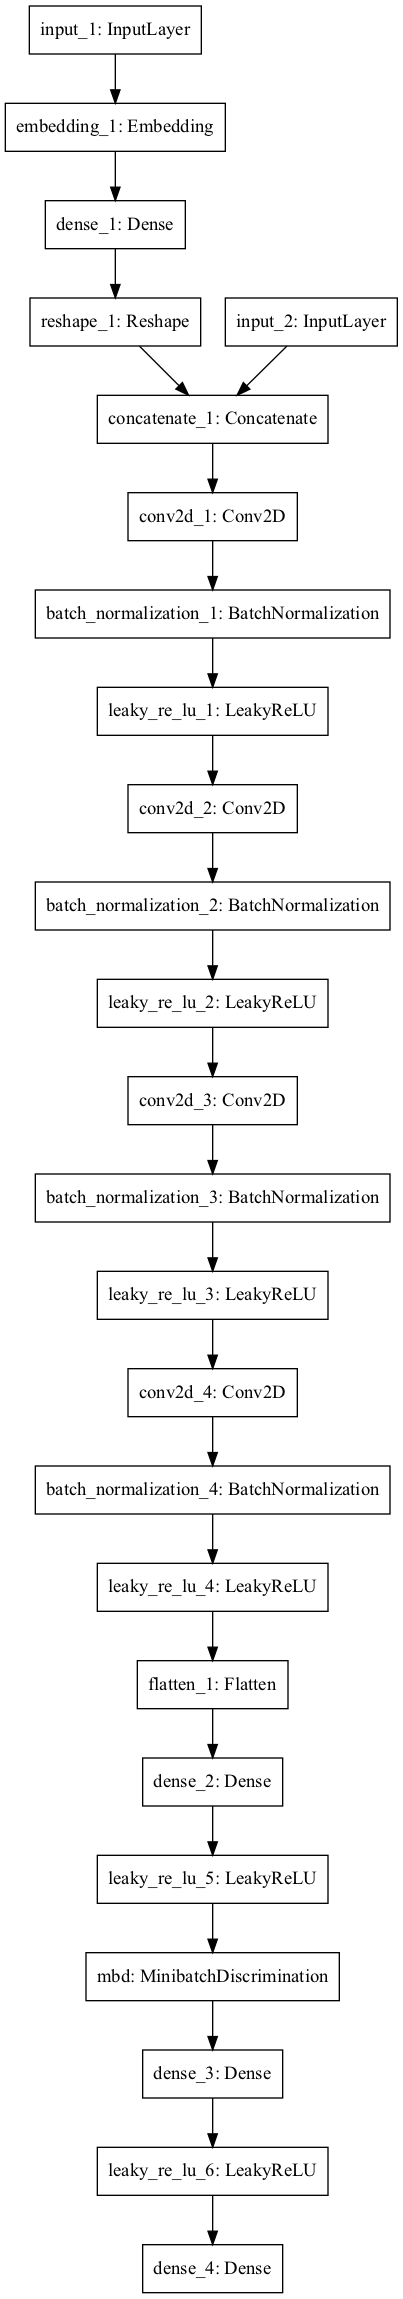

In [6]:
# model visualization
plot_model(conditional_discriminator, to_file='conditional_discriminator.png')

### Standalone Generator

In [7]:
def define_generator():
    # Gaussian Weight Initialization
    init = RandomNormal(mean=0.0, stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(8, 50)(in_label)
    # linear multiplication
    n_nodes = 6 * 6
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((6, 6, 1))(li)
    # image generator input
    in_lat = Input(shape=(100,))
    #Transforming the input into a 6*6 128-channel feature map
    gen = Dense(128*6*6,kernel_initializer=init,input_dim=100,use_bias=False)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((6, 6, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 12x12
    gen = Conv2DTranspose(128,4, strides=2, padding='same', kernel_initializer=init,
                                                    use_bias=False)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 24*24
    gen = Conv2DTranspose(64,4,strides=2, padding='same', kernel_initializer=init,
                                                    use_bias=False)(gen)
    gen = BatchNormalization(momentum=0.9)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 48*48
    gen = Conv2DTranspose(64,4,strides=2, padding='same', kernel_initializer=init,
                                                    use_bias=False)(gen)
    gen = BatchNormalization(momentum=0.9)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, 7, activation='tanh', padding='same',kernel_initializer=init)(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    
    return model

In [8]:
# model summary
conditional_generator = define_generator()
conditional_generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 4608)         460800      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        400         input_3[0][0]                    
____________________________________________________________________________________________

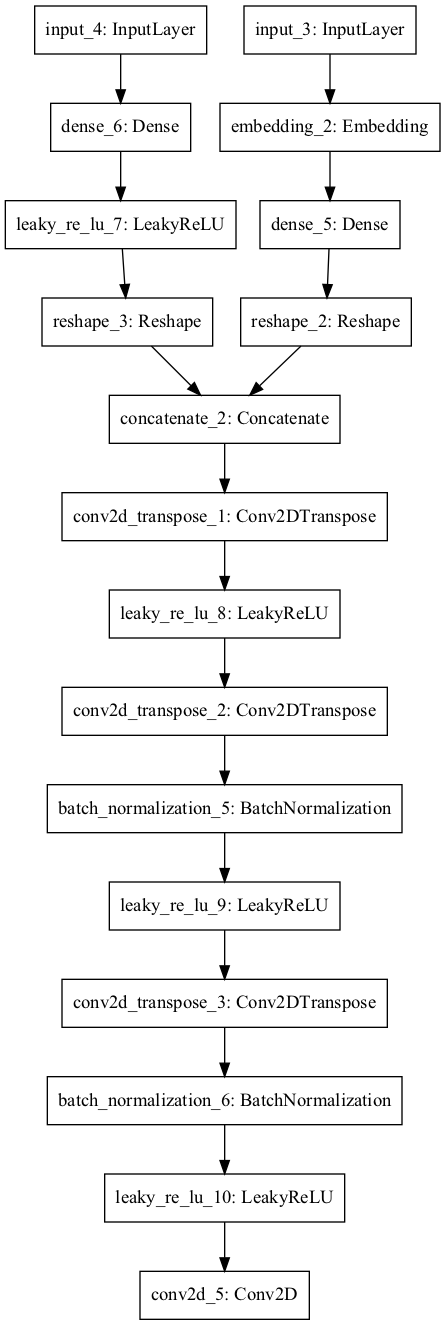

In [9]:
# model visualization
plot_model(conditional_generator, to_file='conditional_generator.png')

### Combined GAN

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_output = generator.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### One sided label smoothing


In [12]:
# select real samples 
def real_samples(dataset,batch_size):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], batch_size)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((batch_size, 1))
    # smoothing class=1 to 0.9
    y = y*0.9
    return [X, labels], y

### Noisy labels

In [15]:
# use the generator to generate n fake examples, with class labels
def fake_samples(generator, dim_latent_space, num_points):
    # generate points in latent space
    X_input, labels_input = latent_points(dim_latent_space, num_points)
    # predict outputs
    images = generator.predict([X_input, labels_input])
    # create class labels
    y = zeros((num_points, 1))
    # number of labels to flip (5%)
    num_to_flip = int(0.05 * y.shape[0])
    # choose labels to flip
    flip_xi = choice([i for i in range(y.shape[0])], size=num_to_flip)
    # invert the labels in place
    y[flip_xi] = 1 - y[flip_xi] 
    return [images, labels_input], y

### Latent Points

In [13]:
# generate points in latent space as input for the generator
def latent_points(dim_latent_space,num_points, n_classes=8):
    # generate points in the latent space
    X_input = randn(dim_latent_space * num_points)
    # reshape into a batch of inputs for the network
    z_input = X_input.reshape(num_points, dim_latent_space)
    # generate labels
    labels = randint(0, n_classes, num_points)
    return [z_input, labels]

### Train

In [16]:
# create a line plot of loss for the gan and save to file
def plot_history(loss1_disc,loss2_disc, g_loss_hist):
    # plot history
    plt.plot(loss1_disc, label='discriminator_real_loss')
    plt.plot(loss2_disc, label='discriminator_fake_loss')
    plt.plot(g_loss_hist, label='generator_loss')
    plt.legend()
    plt.close()

def train(generator_model, discriminator_model, gan_model, dataset, dim_latent_space, num_epochs=9, batch_size=128):
    batch_per_epoch = int(dataset[0].shape[0]/ batch_size)
    half_batch = int(batch_size / 2)
    # lists for keeping track of loss
    loss1_disc,loss2_disc, g_loss_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(num_epochs):
        loss1, loss2, g_loss = list(), list(),list()
        # enumerate batches over the training set
        for j in range(batch_per_epoch):
            # get randomly selected "real" samples
            [X_real, labels_real], y_real = real_samples(dataset, half_batch)
            # update discriminator model weights
            discriminator_loss1, _ = discriminator_model.train_on_batch([X_real, labels_real], y_real) 
            loss1.append(discriminator_loss1)
            # generate "fake" samples
            [X_fake, labels], y_fake = fake_samples(generator_model, dim_latent_space, half_batch)
            # update discriminator model weights
            discriminator_loss2, _ = discriminator_model.train_on_batch([X_fake, labels], y_fake)
            loss2.append(discriminator_loss2)
            # Produce points in latent space to use as the generator's input
            [z_input, labels_input] = latent_points(dim_latent_space,batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            generator_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            g_loss.append(generator_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
        # store losses per epoch 
        loss1_disc.append(mean(loss1))
        loss2_disc.append(mean(loss2))
        g_loss_hist.append(mean(g_loss))
    # save generator model to disk
    filename = 'conditional_generator.sav'
    pickle.dump(generator_model, open(filename, 'wb'))
    # line plots of loss
    plot_history(loss1_disc,loss2_disc, g_loss_hist)

# size of the latent space
dim_latent_space = 100
# create the discriminator
discriminator_model= define_discriminator()
# create the generator
generator_model = define_generator()
# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# load image data
dataset = [X,y]
# train model
train(generator_model,discriminator_model, gan_model, dataset, dim_latent_space)

/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow_core/python/fram

>1, 1/101, d1=2.401, d2=17.812 g=0.000


/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/101, d1=1.107, d2=0.936 g=0.000
>1, 3/101, d1=0.772, d2=0.388 g=0.000
>1, 4/101, d1=0.763, d2=0.201 g=0.000
>1, 5/101, d1=0.692, d2=0.451 g=0.000
>1, 6/101, d1=0.567, d2=0.322 g=0.000
>1, 7/101, d1=0.619, d2=0.368 g=0.005
>1, 8/101, d1=0.515, d2=0.319 g=0.000
>1, 9/101, d1=0.544, d2=0.153 g=0.001
>1, 10/101, d1=0.578, d2=0.425 g=0.000
>1, 11/101, d1=0.657, d2=0.250 g=0.002
>1, 12/101, d1=0.533, d2=0.334 g=0.016
>1, 13/101, d1=0.576, d2=0.349 g=0.000
>1, 14/101, d1=0.587, d2=0.409 g=0.001
>1, 15/101, d1=0.436, d2=0.437 g=0.188
>1, 16/101, d1=0.528, d2=0.333 g=0.033
>1, 17/101, d1=0.488, d2=0.216 g=0.065
>1, 18/101, d1=0.509, d2=0.470 g=0.150
>1, 19/101, d1=0.444, d2=0.431 g=0.317
>1, 20/101, d1=0.499, d2=0.305 g=0.489
>1, 21/101, d1=0.509, d2=0.355 g=0.391
>1, 22/101, d1=0.524, d2=0.449 g=0.320
>1, 23/101, d1=0.436, d2=0.473 g=1.072
>1, 24/101, d1=0.588, d2=0.492 g=0.690
>1, 25/101, d1=0.470, d2=0.521 g=0.655
>1, 26/101, d1=0.474, d2=0.341 g=1.220
>1, 27/101, d1=0.475, d2=0.523 g=

>3, 11/101, d1=0.391, d2=0.272 g=3.747
>3, 12/101, d1=0.382, d2=0.225 g=3.599
>3, 13/101, d1=0.373, d2=0.238 g=2.060
>3, 14/101, d1=0.384, d2=0.164 g=2.564
>3, 15/101, d1=0.361, d2=0.228 g=4.277
>3, 16/101, d1=0.436, d2=0.298 g=3.470
>3, 17/101, d1=0.369, d2=0.300 g=3.914
>3, 18/101, d1=0.385, d2=0.233 g=3.949
>3, 19/101, d1=0.355, d2=0.234 g=3.955
>3, 20/101, d1=0.383, d2=0.257 g=6.661
>3, 21/101, d1=0.373, d2=0.240 g=4.810
>3, 22/101, d1=0.380, d2=0.218 g=3.827
>3, 23/101, d1=0.357, d2=0.312 g=3.353
>3, 24/101, d1=0.381, d2=0.315 g=3.040
>3, 25/101, d1=0.371, d2=0.201 g=4.068
>3, 26/101, d1=0.406, d2=0.221 g=2.524
>3, 27/101, d1=0.378, d2=0.239 g=1.845
>3, 28/101, d1=0.378, d2=0.361 g=4.884
>3, 29/101, d1=0.359, d2=0.229 g=6.102
>3, 30/101, d1=0.392, d2=0.267 g=1.839
>3, 31/101, d1=0.371, d2=0.211 g=2.071
>3, 32/101, d1=0.377, d2=0.214 g=3.512
>3, 33/101, d1=0.359, d2=0.255 g=2.208
>3, 34/101, d1=0.374, d2=0.211 g=2.790
>3, 35/101, d1=0.380, d2=0.231 g=1.657
>3, 36/101, d1=0.385, d2=

>5, 20/101, d1=0.497, d2=0.294 g=0.575
>5, 21/101, d1=0.407, d2=0.292 g=2.740
>5, 22/101, d1=0.559, d2=0.274 g=1.299
>5, 23/101, d1=0.444, d2=0.318 g=1.473
>5, 24/101, d1=0.413, d2=0.248 g=1.466
>5, 25/101, d1=0.397, d2=0.248 g=0.988
>5, 26/101, d1=0.440, d2=0.357 g=1.080
>5, 27/101, d1=0.388, d2=0.264 g=3.307
>5, 28/101, d1=0.734, d2=0.313 g=0.513
>5, 29/101, d1=0.442, d2=0.345 g=3.795
>5, 30/101, d1=0.547, d2=0.167 g=1.619
>5, 31/101, d1=0.429, d2=0.557 g=5.070
>5, 32/101, d1=0.566, d2=0.219 g=3.099
>5, 33/101, d1=0.442, d2=0.265 g=3.706
>5, 34/101, d1=0.416, d2=0.264 g=3.784
>5, 35/101, d1=0.566, d2=0.620 g=6.851
>5, 36/101, d1=0.542, d2=0.186 g=5.144
>5, 37/101, d1=0.444, d2=0.579 g=8.514
>5, 38/101, d1=1.153, d2=0.428 g=3.791
>5, 39/101, d1=0.423, d2=0.219 g=4.340
>5, 40/101, d1=0.421, d2=0.210 g=3.500
>5, 41/101, d1=0.500, d2=0.452 g=3.983
>5, 42/101, d1=0.425, d2=0.240 g=3.602
>5, 43/101, d1=0.514, d2=0.332 g=1.624
>5, 44/101, d1=0.380, d2=0.298 g=4.107
>5, 45/101, d1=0.614, d2=

>7, 29/101, d1=0.382, d2=0.271 g=3.677
>7, 30/101, d1=0.428, d2=0.310 g=3.777
>7, 31/101, d1=0.383, d2=0.209 g=4.009
>7, 32/101, d1=0.395, d2=0.260 g=3.216
>7, 33/101, d1=0.375, d2=0.215 g=3.896
>7, 34/101, d1=0.369, d2=0.261 g=3.865
>7, 35/101, d1=0.455, d2=0.218 g=2.251
>7, 36/101, d1=0.385, d2=0.209 g=2.462
>7, 37/101, d1=0.369, d2=0.248 g=2.041
>7, 38/101, d1=0.368, d2=0.186 g=0.950
>7, 39/101, d1=0.415, d2=0.242 g=0.246
>7, 40/101, d1=0.369, d2=0.270 g=0.950
>7, 41/101, d1=0.365, d2=0.207 g=1.084
>7, 42/101, d1=0.372, d2=0.136 g=0.387
>7, 43/101, d1=0.377, d2=0.223 g=0.281
>7, 44/101, d1=0.372, d2=0.329 g=1.391
>7, 45/101, d1=0.434, d2=0.166 g=0.493
>7, 46/101, d1=0.374, d2=0.293 g=1.945
>7, 47/101, d1=0.360, d2=0.267 g=0.890
>7, 48/101, d1=0.367, d2=0.195 g=0.330
>7, 49/101, d1=0.404, d2=0.238 g=0.256
>7, 50/101, d1=0.360, d2=0.246 g=0.786
>7, 51/101, d1=0.478, d2=0.235 g=0.149
>7, 52/101, d1=0.376, d2=0.294 g=1.477
>7, 53/101, d1=0.456, d2=0.179 g=0.804
>7, 54/101, d1=0.379, d2=

>9, 38/101, d1=0.456, d2=0.243 g=3.037
>9, 39/101, d1=0.437, d2=0.253 g=3.599
>9, 40/101, d1=0.447, d2=0.264 g=2.406
>9, 41/101, d1=0.405, d2=0.287 g=4.227
>9, 42/101, d1=0.477, d2=0.309 g=2.990
>9, 43/101, d1=0.387, d2=0.203 g=3.529
>9, 44/101, d1=0.435, d2=0.314 g=3.089
>9, 45/101, d1=0.418, d2=0.175 g=3.668
>9, 46/101, d1=0.414, d2=0.282 g=2.812
>9, 47/101, d1=0.382, d2=0.302 g=3.039
>9, 48/101, d1=0.418, d2=0.271 g=2.979
>9, 49/101, d1=0.517, d2=0.476 g=2.996
>9, 50/101, d1=0.424, d2=0.174 g=1.922
>9, 51/101, d1=0.414, d2=0.303 g=2.348
>9, 52/101, d1=0.420, d2=0.223 g=1.751
>9, 53/101, d1=0.432, d2=0.232 g=1.867
>9, 54/101, d1=0.417, d2=0.289 g=2.213
>9, 55/101, d1=0.457, d2=0.191 g=1.977
>9, 56/101, d1=0.362, d2=0.277 g=1.217
>9, 57/101, d1=0.429, d2=0.425 g=1.912
>9, 58/101, d1=0.461, d2=0.276 g=1.041
>9, 59/101, d1=0.433, d2=0.237 g=1.861
>9, 60/101, d1=0.411, d2=0.234 g=0.807
>9, 61/101, d1=0.413, d2=0.258 g=0.717
>9, 62/101, d1=0.413, d2=0.247 g=0.790
>9, 63/101, d1=0.391, d2=